<a href="https://colab.research.google.com/github/ngjimenez/1-Audio-Classification/blob/main/Audio_Classification_Harry_Potter_vs_Star_Wars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Solution

# 1. Author

* Student Name: Natalie Jimenez
* Student ID: 210347863

# 2. Problem Formulation

**Describe the machine learning problem that you want to solve and explain what's interesting about it.**

As part of this project, we want to classify an input audio samples as the Harry Potter theme song or Star Wars theme song, regardless of whether the sample is a hum or whistle.

# 3. Machine Learning Pipeline
**Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. Note that your pipeline does not need to include all the stages.**


![picture](https://drive.google.com/uc?export=view&id=1P25pmY-GmGjf5cf4geTuMKxnpA0d3_sW)

### Additional Comments
* Stage 1: I saved all the Harry Potter audio samples in one folder and all the Star Wars samples in another so I wouldn't have to worry about inconsistent naming conventions. <br>

* Stage 2: I looked at 8 different features before picking four of them. See Section 10.1 - Feature Selection. I also saved these to a CSV file because the feature extraction took too long for the 800 total samples

# 4. Transformation Stage
**Describe any transformations, such as feature extraction. Identify input and output.**

## Section 4.1 - Feature Extaction

**Input**: audio waveforms

As mentioned before, I looked at 8 different features, and a summary of this can be found in Section 10.1 - Feature Selection. I looked at the mean of the following features:
* Power
* Spectral Rolloff
* Spectral Bandwidth
* Spectral Centroid
* MFCCs
* Tempo
* Pitch
* Root Mean Square Energy
<br>
<br>

I found these features through a variety of sources:
* Starter Kit
* A Study called "A New Front-End for Classification of Non-Speech Sounds: A Study on Human Whistle", which described the use of Spectral Rolloff, Spectral Bandwidth, Spectral Centroid, MFCCs in classifying whistle and speech audio samples.
<br>
(Nandwana, Mahesh & Boril, Hynek & Hansen, John. (2015). A New Front-End for Classification of Non-Speech Sounds: A Study on Human Whistle. 10.21437/Interspeech.2015-436.)
<br>
<br>

I then plotted the distribution of each values on a line plot and I did not observe any good separation between the Harry Potter and Star Wars samples. However, I did note:
* Spectral Rolloff mean, Spectral Centroid mean, and Spectral Bandwidth mean were highly linearly correlated. So, I decided to exclude Spectral centroid and Spectral Bandwidth because having linearly predictors could bias the analysis.

* Spectral Rolloff mean, MFCCs mean, Tempo mean, and Power were not linearly correlated, so I chose these as the features for this project.


**Output**: means of Spectral Rolloff mean, MFCCs mean, Tempo mean, and Power

## Section 4.2: Standardization of Features

**Input**: Extracted Features

I used Standard Scaler to standardize my chosen features for the following reasons:
* The change of the Power feature was from 0 to about 0.54, while the Spectral Rolloff values were in the thousands. So, these features had wildly different ranges.
* I was planning on using SVM, and the scale of features influences the hyperplane since it is based on distances. So, having similar scales is best.

**Output**: Standardized Extracted Features



# 5. Modelling

**Describe the ML models that you will implement.**

Given that none of the individually plotted extracted, standardized features separated the songs, I mildly suspected that the machine learning models would yield a mediocre accuracy. Nevertheless, I employed the following:

* Simple SVM with default parameters - to get a basic feel for how the classification was going to work.

* GridSearchCV with SVM - I used GridSearchCV to tune the parameters:
  * Cost: [0.1, 1, 10, 100, 1000] - the lower the cost, the softer the margins. I predicted that lower costs would be optimal because I believe there isn't good separation between songs.

  * Gamma: [1, 0.1, 0.01, 0.001, 0.0001] - the closer the gamma value is to zero, the larger the variance and influence of a data point

  * CV: 5 (online research suggested 5 or 10 as the typical number of folds)

* GridSearchCV with RFC
  * n_estimators: [50, 100, 200] - 
  * max_features: [0.1, 0.25] - 


# 6. Methodology
**Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)**


After the data has been split into training and validation sets, I standardize each and pass the inputs through the models. I will also tune the parameters with GridSearchCV from SK-Learn. I will assess the model performance by looking at the models with best estimators and compare training/validation accuracies to each to check for overfitting, and I look at confusion matrix of each best estimator to compare with other models.

# 7. Dataset

## Section 7.1 - Describe Dataset

*Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.*


For this project, I will be using the entire available Harry Potter and Star Wars dataset. I have saved the Harry Potter files in one folder and the Star Wars files in another folder to bypass the difficulties of improper naming conventions. 

## Section 7.2 - Load Data

In [ ]:
# import necessary libraries
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Section 7.3 - Feature Extraction

In [ ]:
def get_features(files):
  features = []
  iteration = 0
# rolloff, centroid, power, mfccs

  for i in range(len(files)):
    iteration += 1
    #print(iteration)

    x, sampling_rate = librosa.load(files[i],sr=None)
    x = x/np.max(np.abs(x))

    # Power
    power = np.sum(x**2)/len(x)

    # Spectral Rolloff
    sr = librosa.feature.spectral_rolloff(x, sr=sampling_rate)
    sr_mean = sr.mean()

    # MFCCs
    mfcc = librosa.feature.mfcc(x, sr=sampling_rate)
    mfcc_mean = mfcc.mean()

    # Tempo
    tempo = librosa.feature.tempogram(x, sr=sampling_rate)
    tempo_mean = tempo.mean()

    features_i = [power, sr_mean, mfcc_mean, tempo_mean]
    features.append(features_i) 

  return features



```
# Extract features from HP/SW
fhp = get_features(files_hp)
print(f'The number of features we extracted from the Harry Potter samples is: {len(fhp[0])}')
print(f'The number of samples in our Harry Potter feature extraction is: {len(fhp)}')

fsw = get_features(files_sw)
print(f'\nThe number of features we extracted from the Star Wars samples is: {len(fsw[0])}')
print(f'The number of samples in our Star Wars feature extraction is: {len(fsw)}')
```

The number of features we extracted from the Harry Potter samples is: 4 <br>
The number of samples in our Harry Potter feature extraction is: 411 
<br><br>

The number of features we extracted from the Star Wars samples is: 4 <br>
The number of samples in our Star Wars feature extraction is: 413





```
# Concatenate features into one list
all_features = fhp.copy()
for item in fsw:
  all_features.append(item)

# Convert list to array
features_array = np.array(all_features)

print(f'The shape of the final array is: {features_array.shape}')
```

The shape of the final array is: (824, 4)



```
# Assign Harry Potter as 1
hp = []
for i in range(len(fhp)):
  hp.append(1)

# Assign Star Wars as 0
sw = []
for i in range(len(fsw)):
  sw.append(0)

# Concatenate into one array
labels = hp
for label in sw:
  labels.append(label)

labels = np.asarray(labels)

print(f'There are {len(labels)} labels.')
```

There are 824 labels.



```
all_features = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/HP_and_SW_unstandardized.csv", names=['Power', 'SR_Mean', 'SB_Mean', 'SC_Mean', 'Labels']) 
all_features
```



Then the features were saved as a CSV file.

In [ ]:
# all_features_df.to_csv("/content/drive/MyDrive/Data/MLEndHW/HP_and_SW_unstandardized.csv", header=None)

## Section 7.4 - Import Data

In [ ]:
all_features = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/HP_and_SW_unstandardized.csv", names=['Power', 'SR_Mean', 'MFCCs_Mean', 'Tempo_Mean', 'Labels']) 
all_features

,Power,SR_Mean,MFCCs_Mean,Tempo_Mean,Labels
0,0.001961,7910.371662,-8.052431,0.124224,1
1,0.020419,8731.602412,-1.585301,0.230652,1
2,0.053579,3936.080693,-2.880146,0.231734,1
3,0.037227,9284.104372,-7.144587,0.269945,1
4,0.093276,1557.207009,-7.515192,0.218913,1
...,...,...,...,...,...
819,0.023949,2281.153930,-19.837202,0.202143,0
820,0.028499,3073.414954,-13.222474,0.090971,0
821,0.050066,3573.084933,-11.973355,0.098417,0
822,0.001234,6427.243089,-29.980549,0.192049,0


In [ ]:
# Convert features to array
features_array = all_features.iloc[:, 0:4].values
features_array.shape

(824, 4)

In [ ]:
# Convert labels column to array
labels = all_features.iloc[:, 4].values
labels.shape

(824,)

## Section 7.5 - Split Data into Training and Validation Sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features_array,labels,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((576, 4), (248, 4), (576,), (248,))

## Section 7.6 - Standardize Values

In [ ]:
# Standardize values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Section 7.7 - Visualize Standardized Extracted Features of the Training Set

In [ ]:
features_df = pd.DataFrame(data=X_train, columns=['Power', 'SR_Mean', 'MFCCs_Mean', 'Tempo_Mean'])
features_df['Labels'] = y_train.tolist()
features_df['Plot Y'] = 0
features_df

,Power,SR_Mean,MFCCs_Mean,Tempo_Mean,Labels,Plot Y
0,-0.368024,3.929309,0.809325,1.550884,0,0
1,-0.049355,-0.958677,0.733050,0.301156,0,0
2,-0.422146,1.096789,-0.627056,-0.866514,0,0
3,-0.750079,-0.114506,0.824352,0.458924,0,0
4,-0.621494,1.448672,0.220654,-0.937669,0,0
...,...,...,...,...,...,...
571,0.246394,-0.182758,-1.122915,0.311744,0,0
572,0.358538,-1.091563,1.042732,0.179463,0,0
573,-0.378035,0.092367,-0.837411,-0.147067,1,0
574,-0.662345,-0.313471,0.224724,2.110384,1,0


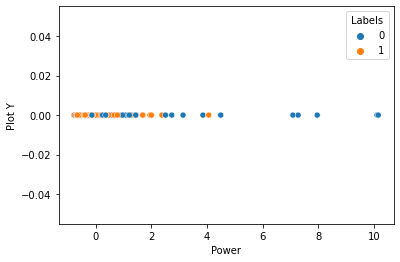

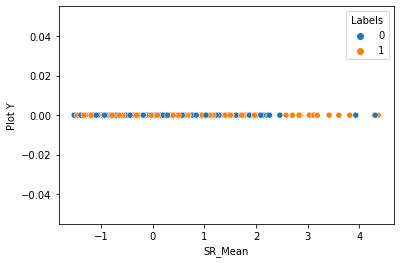

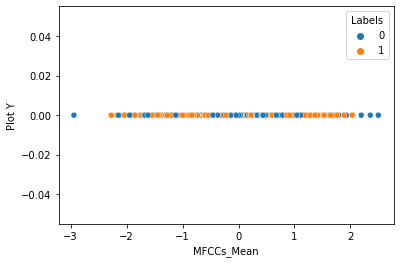

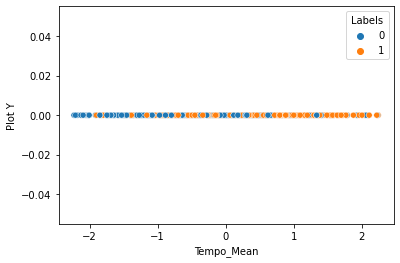

In [ ]:
cols = features_df.columns[0:4]
for col in cols:
  sns.scatterplot(x=col, y="Plot Y", data=features_df, hue="Labels")
  plt.show()

As seen above, it does not look like there is an observable difference between Harry Potter labels (1) and Star Wars (0).

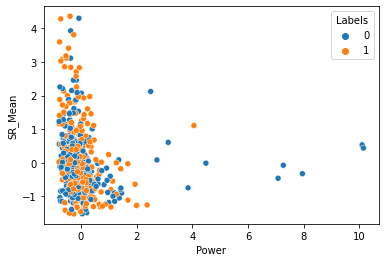

In [ ]:
# Visualize SB Mean vs. SB Mean
sns.scatterplot(x="Power", y="SR_Mean", data=features_df, hue="Labels")

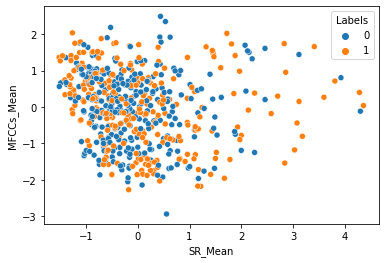

In [ ]:
# Visualize SR Mean vs. MFCCs
sns.scatterplot(x="SR_Mean", y="MFCCs_Mean", data=features_df, hue="Labels")

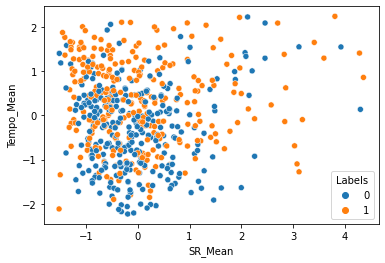

In [ ]:
# Visualize SR Mean vs. MFCCs
sns.scatterplot(x="SR_Mean", y="Tempo_Mean", data=features_df, hue="Labels")

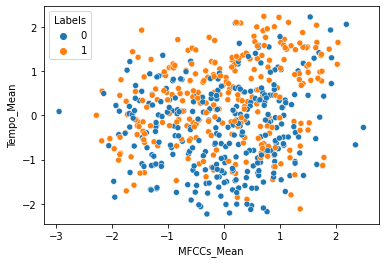

In [ ]:
# Visualize SR Mean vs. MFCCs
sns.scatterplot(x="MFCCs_Mean", y="Tempo_Mean", data=features_df, hue="Labels")

As mentioned in Section 4.1, these features were chosen because there is no linear correlation between them. 

# 8. Results

## Section 8.1 - Basic SVM

In [ ]:
from sklearn import svm

svm_model = svm.SVC(C=1)
svm_model.fit(X_train,y_train)

yt_p = svm_model.predict(X_train)
yv_p = svm_model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', svm_model.support_vectors_.shape)

Training Accuracy 0.6631944444444444
Validation  Accuracy 0.5604838709677419
The support vectors are (458, 4)


From employing an SVM model, we see that the training accuracy is about 66% and the validation accuracy is about 56%. Given that the accuracies are not very close to one another, it seems like the model is overfitting. Considering that the accuracy hovers at around 60%, this is only slightly better than a random coin toss for classification.

## Section 8.2 - GridSearchCV SVM

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [10, 1, 0.1, 0.01, 0.001],}

svm_model = svm.SVC()

svm_gridsearch = GridSearchCV(svm_model, param_grid, cv=5)
svm_gridsearch.fit(X_train, y_train)

print('Best hyperparameter setting: {0}.'.format(svm_gridsearch.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(svm_gridsearch.best_score_))
print('Training dataset accuracy of best hyperparameter setting: {0}.'.format(svm_gridsearch.score(X_train, y_train)))
print('Validation dataset accuracy of best hyperparameter setting: {0}.'.format(svm_gridsearch.score(X_val, y_val)))

Best hyperparameter setting: SVC(C=1, gamma=0.1).
Average accuracy across folds of best hyperparameter setting: 0.6370764617691154.
Training dataset accuracy of best hyperparameter setting: 0.6527777777777778.
Validation dataset accuracy of best hyperparameter setting: 0.5725806451612904.


The GridSearchCV Model with SVM actually produced training and validation accuracies that are closer to one another as compared to the previous SVM model. This is likely because we used cross-validation (5 folds), which reduced bias.

In [ ]:
yt_p = svm_gridsearch.best_estimator_.predict(X_train)
yv_p = svm_gridsearch.best_estimator_.predict(X_val)

train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=yt_p)
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=yv_p)
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Normalized training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalized validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Normalized training confusion matrix:
 [[0.72390572 0.27609428]
 [0.42293907 0.57706093]]

Normalized validation confusion matrix:
 [[0.56034483 0.43965517]
 [0.41666667 0.58333333]]



In the SKLearn confusion matrix function, rows represent actual classes and columns predicted classes, and their indices (0, and 1) correspond to each label.<br><br>
In looking at the normalized confusion matrix for the training data, we observe the following:
* About 72% of the Star Wars samples were correctly identified, and about 28% were incorrectly labeled as Harry Potter
* About 42% of the Harry Potter were correctly identified, and about 58% were incorrectly labeled as Star Wars.

## Section 8.3 - GridSearch CV Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': [50, 100, 200], 'max_features': [0.1, 0.25]}

rfc = RandomForestClassifier()
rfc_gridsearch = GridSearchCV(rfc, parameters, cv=5)
rfc_gridsearch.fit(X_train, y_train)

print('Best hyperparameter setting: {0}.'.format(rfc_gridsearch.best_estimator_))
print('Average accuracy across folds of best hyperparameter setting: {0}.'.format(rfc_gridsearch.best_score_))
print('Training dataset accuracy of best hyperparameter setting: {0}.'.format(rfc_gridsearch.score(X_train, y_train)))
print('Validation dataset accuracy of best hyperparameter setting: {0}.'.format(rfc_gridsearch.score(X_val, y_val)))

Best hyperparameter setting: RandomForestClassifier(max_features=0.1, n_estimators=200).
Average accuracy across folds of best hyperparameter setting: 0.6025487256371813.
Training dataset accuracy of best hyperparameter setting: 1.0.
Validation dataset accuracy of best hyperparameter setting: 0.5604838709677419.


The training set accuracy is 100% and the validation accuracy is about 60%, so the model is grossly overfitted. 

In [ ]:
yt_p = rfc_gridsearch.best_estimator_.predict(X_train)
yv_p = rfc_gridsearch.best_estimator_.predict(X_val)

train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=yt_p)
train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]

val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=yv_p)
val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

print('Normalized training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
print('Normalized validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

Normalized training confusion matrix:
 [[1. 0.]
 [0. 1.]]

Normalized validation confusion matrix:
 [[0.52586207 0.47413793]
 [0.40909091 0.59090909]]



The confusion matrix for the training data shows that each sample has been correctly identified which leads me to believe the model is overfitted, which is a risk associated with this classification method.

# 9. Conclusions

**Conclusions** <br>
All of the models had validation accuracies at around 60%, which means the classification models were only slightly better than a random coin toss. If I had to choose one model, I would go with the SVM model and parameters found through GridSearch CV because the training and validation accuracies are closer to one another, and the hyperparameters were found through tuning.
<br>
<br>
**Improvements**<br>
I did not have much confidence in finding a model with higher training and validation accuracies because through the feature selection process, I noted my methods did not produce any separation between the Harry Potter and Star Wars samples (see below for the features I looked at). 


I think part of this is due to my limited knowledge in the audio engineering space. Though I spent days researching the audio feature extraction space, I don't think it was enough to give me a solid background to extract features well enough. I looked at peer reviewed journal articles and blog posts, and most involved producing spectrograms as input for a neural network (neural networks is outside the scope of my abilities at this point). However, many resources suggested finding the average of the audio features and concatenating them as a feature vector, which is what I ended up doing.

# Section 10 - Appendix

## Section 10.1 - Inspect Different Features

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
def get_features_3(files):
  features = []
  iteration = 0
# rolloff, centroid, power, mfccs

  for i in range(50):
    iteration += 1
    #print(iteration)

    x, sampling_rate = librosa.load(files[i],sr=None)
    x = x/np.max(np.abs(x))

    # Power
    power = np.sum(x**2)/len(x)

    # Spectral Rolloff
    sr = librosa.feature.spectral_rolloff(x, sr=sampling_rate)
    sr_mean = sr.mean()

    # Spectral Bandwidth
    sb = librosa.feature.spectral_bandwidth(x, sr=sampling_rate)
    sb_mean = sb.mean()

    # Spectral Centroid
    sc = librosa.feature.spectral_centroid(x, sr=sampling_rate)
    sc_mean = sc.mean()

    # MFCCs
    mfcc = librosa.feature.mfcc(x, sr=sampling_rate)
    mfcc_mean = mfcc.mean()

    # Tempo
    tempo = librosa.feature.tempogram(x, sr=sampling_rate)
    tempo_mean = tempo.mean()

    # Pitch Mean
    f0, voiced_flag = getPitch(x,sampling_rate,winLen=0.02)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0

    # RMSE
    rms = librosa.feature.rms(x)
    rms_mean = rms.mean()

    features_i = [power, sr_mean, sb_mean, sc_mean, mfcc_mean, tempo_mean, pitch_mean, rms_mean]
    features.append(features_i) 

  return features

In [ ]:
sample_path_hp = '/content/drive/MyDrive/Data/MLEndHW/Repository_HP/*.wav'
files_hp = glob.glob(sample_path_hp)
print(f'The Harry Potter folder has {len(files_hp)} audio files.')

sample_path_sw = '/content/drive/MyDrive/Data/MLEndHW/Repository_StarWars/*.wav'
files_sw = glob.glob(sample_path_sw)
print(f'The Star Wars folder has {len(files_sw)} audio files.')

The Harry Potter folder has 411 audio files.
The Star Wars folder has 413 audio files.


In [ ]:
# Extract features from HP/SW
fhp = get_features_3(files_hp)
print(f'The number of features we extracted from the Harry Potter samples is: {len(fhp[0])}')
print(f'The number of samples in our Harry Potter feature extraction is: {len(fhp)}')

fsw = get_features_3(files_sw)
print(f'\nThe number of features we extracted from the Star Wars samples is: {len(fsw[0])}')
print(f'The number of samples in our Star Wars feature extraction is: {len(fsw)}')

The number of features we extracted from the Harry Potter samples is: 8
The number of samples in our Harry Potter feature extraction is: 50

The number of features we extracted from the Star Wars samples is: 8
The number of samples in our Star Wars feature extraction is: 50


In [ ]:
# Concatenate features into one list
all_features = fhp.copy()
for item in fsw:
  all_features.append(item)

# Convert list to array
features_array = np.array(all_features)

print(f'The shape of the final array is: {features_array.shape}')

The shape of the final array is: (100, 8)


In [ ]:
## Make Y Labels
# Assign Harry Potter as 1
hp = []
for i in range(len(fhp)):
  hp.append(1)

# Assign Star Wars as 0
sw = []
for i in range(len(fsw)):
  sw.append(0)

# Concatenate into one array
labels = hp
for label in sw:
  labels.append(label)

labels = np.asarray(labels)

print(f'There are {len(labels)} labels.')

There are 100 labels.


In [ ]:
all_features = pd.DataFrame(features_array)
all_features['labels'] = labels
all_features

,0,1,2,3,4,5,6,7,labels
0,0.001961,7910.371662,5142.033508,2965.937031,-8.052431,0.124224,107.628769,0.032111,1
1,0.020419,8731.602412,5266.609682,4031.218885,-1.585301,0.230652,408.684951,0.116072,1
2,0.053579,3936.080693,4765.788842,2475.002768,-2.880146,0.231734,179.379037,0.205222,1
3,0.037227,9284.104372,5767.036431,4436.822076,-7.144587,0.269945,396.012292,0.141385,1
4,0.093276,1557.207009,1981.262513,951.820397,-7.515192,0.218913,184.280074,0.272731,1
...,...,...,...,...,...,...,...,...,...
95,0.015866,4429.959676,2939.081412,2324.563675,-12.135299,0.120440,237.338895,0.098401,0
96,0.017924,9888.533285,5378.549447,4293.029730,-16.122620,0.231638,313.891152,0.111173,0
97,0.003295,8731.520325,5391.190109,4183.125680,-19.895231,0.157024,292.964942,0.033736,0
98,0.018064,4902.316508,4299.939094,2732.719922,-9.351375,0.163032,148.410125,0.101859,0


In [ ]:
all_features.to_csv("/content/drive/MyDrive/Data/MLEndHW/basic_feature_selection.csv", header=None)

In [ ]:
all_features = pd.read_csv("/content/drive/MyDrive/Data/MLEndHW/basic_feature_selection.csv", names=['Power', 'SR_Mean', 'SB_Mean', 'SC_Mean', 'MFCCs_Mean', 'Tempo_Mean', 'Pitch_Mean', 'RMS', 'Labels'])
all_features['Plot Y'] = 0 
all_features

,Power,SR_Mean,SB_Mean,SC_Mean,MFCCs_Mean,Tempo_Mean,Pitch_Mean,RMS,Labels,Plot Y
0,0.001961,7910.371662,5142.033508,2965.937031,-8.052431,0.124224,107.628769,0.032111,1,0
1,0.020419,8731.602412,5266.609682,4031.218885,-1.585301,0.230652,408.684951,0.116072,1,0
2,0.053579,3936.080693,4765.788842,2475.002768,-2.880146,0.231734,179.379037,0.205222,1,0
3,0.037227,9284.104372,5767.036431,4436.822076,-7.144587,0.269945,396.012292,0.141385,1,0
4,0.093276,1557.207009,1981.262513,951.820397,-7.515192,0.218913,184.280074,0.272731,1,0
...,...,...,...,...,...,...,...,...,...,...
95,0.015866,4429.959676,2939.081412,2324.563675,-12.135299,0.120440,237.338895,0.098401,0,0
96,0.017924,9888.533285,5378.549447,4293.029730,-16.122620,0.231638,313.891152,0.111173,0,0
97,0.003295,8731.520325,5391.190109,4183.125680,-19.895231,0.157024,292.964942,0.033736,0,0
98,0.018064,4902.316508,4299.939094,2732.719922,-9.351375,0.163032,148.410125,0.101859,0,0


In [ ]:
features_array = all_features.iloc[:, 0:8].values
features_array.shape

(100, 8)

In [ ]:
labels = all_features.iloc[:, 8].values
labels.shape

(100,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(features_array,labels,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((70, 8), (30, 8), (70,), (30,))

In [ ]:
# Standardize values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
features_df = pd.DataFrame(data=X_train, columns=['Power', 'SR_Mean', 'SB_Mean', 'SC_Mean', 'MFCCs_Mean', 'Tempo_Mean', 'Pitch_Mean', 'RMS'])
features_df['Labels'] = y_train.tolist()
features_df['Plot Y'] = 0
features_df

,Power,SR_Mean,SB_Mean,SC_Mean,MFCCs_Mean,Tempo_Mean,Pitch_Mean,RMS,Labels,Plot Y
0,-0.466369,1.622782,1.519208,1.859504,0.208314,0.877512,1.715532,-0.749807,0,0
1,-0.545595,-1.174545,-0.260730,-1.148162,1.305330,-0.217551,-1.293649,-0.802033,1,0
2,-0.129446,-1.100638,-0.331847,-1.102913,1.758370,-0.760930,-1.088290,0.057141,1,0
3,-0.358623,-0.003853,0.473490,0.133577,-1.033178,-0.049842,0.959044,-0.482998,1,0
4,-0.506713,2.817413,2.185708,2.846071,-0.996992,-0.002812,0.895253,-1.052192,1,0
...,...,...,...,...,...,...,...,...,...,...
65,-0.081194,-1.076284,-0.481910,-1.113422,1.587269,-0.696015,-1.125297,0.087100,0,0
66,-0.325686,0.391592,0.168942,0.610233,-0.324117,1.135505,1.700183,-0.706123,1,0
67,-0.036914,0.248637,0.173315,0.897617,-1.700886,1.791438,1.508200,-0.009257,1,0
68,-0.271589,-0.932181,-0.669709,-0.866818,0.162303,-0.641837,-0.039966,-0.026272,0,0


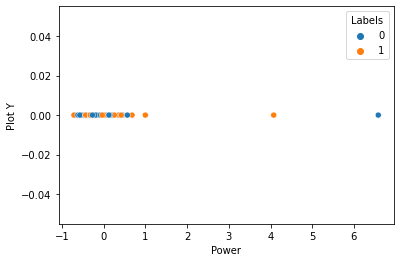

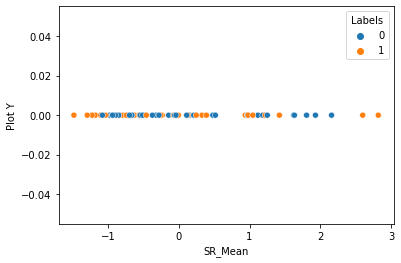

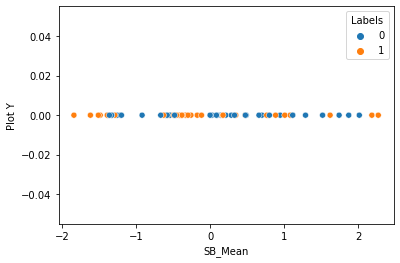

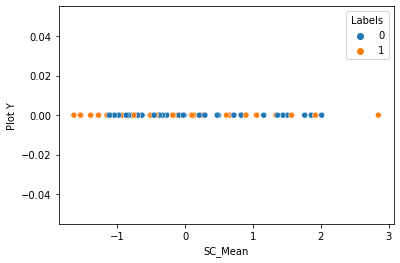

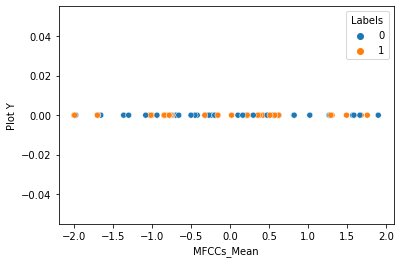

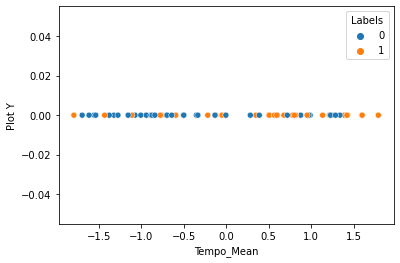

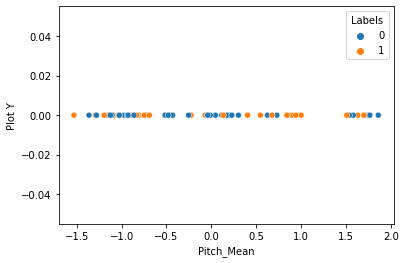

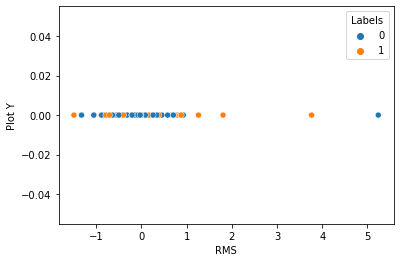

In [ ]:
cols = features_df.columns[0:8]
for col in cols:
  sns.scatterplot(x=col, y="Plot Y", data=features_df, hue="Labels")
  plt.show()

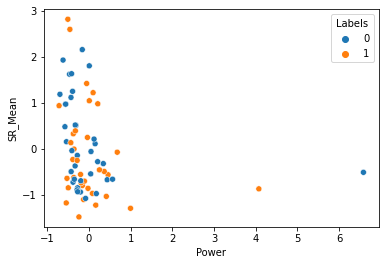

In [ ]:
sns.scatterplot(x="Power", y="SR_Mean", data=features_df, hue="Labels")

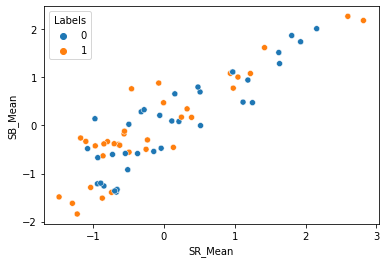

In [ ]:
sns.scatterplot(x="SR_Mean", y="SB_Mean", data=features_df, hue="Labels")

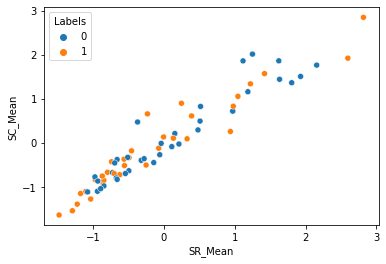

In [ ]:
sns.scatterplot(x="SR_Mean", y="SC_Mean", data=features_df, hue="Labels")

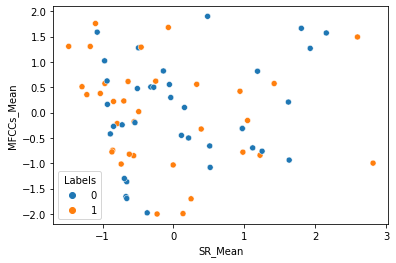

In [ ]:
sns.scatterplot(x="SR_Mean", y="MFCCs_Mean", data=features_df, hue="Labels")

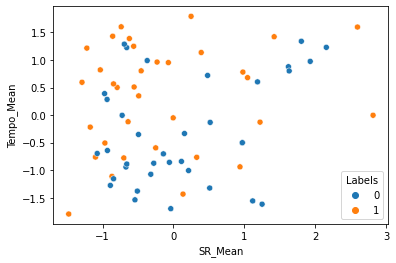

In [ ]:
sns.scatterplot(x="SR_Mean", y="Tempo_Mean", data=features_df, hue="Labels")

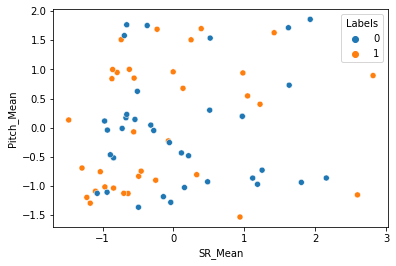

In [ ]:
sns.scatterplot(x="SR_Mean", y="Pitch_Mean", data=features_df, hue="Labels")

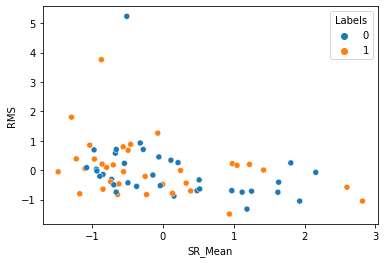

In [ ]:
sns.scatterplot(x="SR_Mean", y="RMS", data=features_df, hue="Labels")

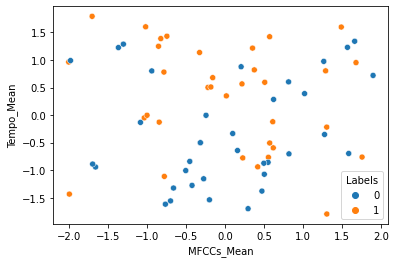

In [ ]:
sns.scatterplot(x="MFCCs_Mean", y="Tempo_Mean", data=features_df, hue="Labels")

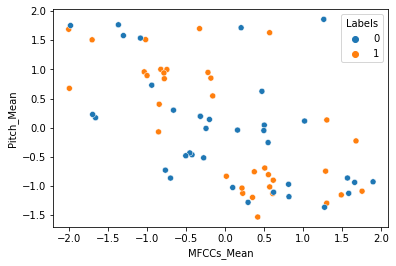

In [ ]:
sns.scatterplot(x="MFCCs_Mean", y="Pitch_Mean", data=features_df, hue="Labels")

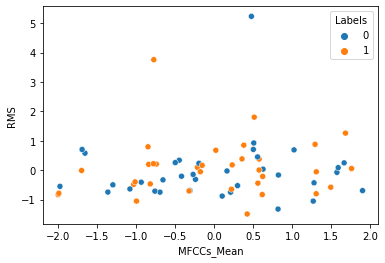

In [ ]:
sns.scatterplot(x="MFCCs_Mean", y="RMS", data=features_df, hue="Labels")

* SR_Mean, SC_Mean, and SB_Mean are highly correlated.

* SR_Mean, MFCCs_Mean, Tempo_mean, Pitch_Mean are not

* Power, MFCCs_Mean, SR_Mean, Tempo_Mean